In [1]:
!pip install -q python-igraph scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.7 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.90MB/s]


Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def visualize_k_nearest_neighbors_graph(unique_vectors, k):
    """
    Builds an unweighted graph with python-igraph where each unique vector is a node.
    Each node is connected to its k nearest neighbors (excluding itself).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, d) containing feature vectors.
        k (int): Number of nearest neighbors for each node.

    Returns:
        g (igraph.Graph): The constructed unweighted graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building unweighted k-NN graph for {n} nodes...")

    # Find k nearest neighbors for each node. Note: The first neighbor is the point itself.
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)

    edge_list = []
    for i, neigh in enumerate(indices):
        # Skip the first neighbor (self) and add undirected edges only once.
        for j in neigh[1:]:
            if i < j:
                edge_list.append((i, j))

    # Create an undirected graph.
    g = ig.Graph(n=n, edges=edge_list, directed=False)
    print(f"Unweighted k-NN graph built with {len(edge_list)} edges.")
    return g

g = visualize_k_nearest_neighbors_graph(unique_vectors, 5)


Building unweighted k-NN graph for 6726 nodes...
Unweighted k-NN graph built with 15285 edges.


In [5]:
# prompt: print 5 biggest connected components in g and how many nodes and edges are in each

# Find connected components
clusters = g.clusters()

# Sort clusters by size in descending order and get the 5 largest
largest_clusters = sorted(clusters, key=len, reverse=True)[:5]

# Print information about the 5 largest connected components
for i, cluster in enumerate(largest_clusters):
    subgraph = g.subgraph(cluster)
    print(f"Connected Component {i+1}:")
    print(f"  Number of nodes: {subgraph.vcount()}")
    print(f"  Number of edges: {subgraph.ecount()}")


Connected Component 1:
  Number of nodes: 6478
  Number of edges: 15254
Connected Component 2:
  Number of nodes: 4
  Number of edges: 3
Connected Component 3:
  Number of nodes: 3
  Number of edges: 2
Connected Component 4:
  Number of nodes: 3
  Number of edges: 2
Connected Component 5:
  Number of nodes: 3
  Number of edges: 2


<ipython-input-5-c1d80609f63a>:4: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  clusters = g.clusters()


Average degree: 4.5450490633363065


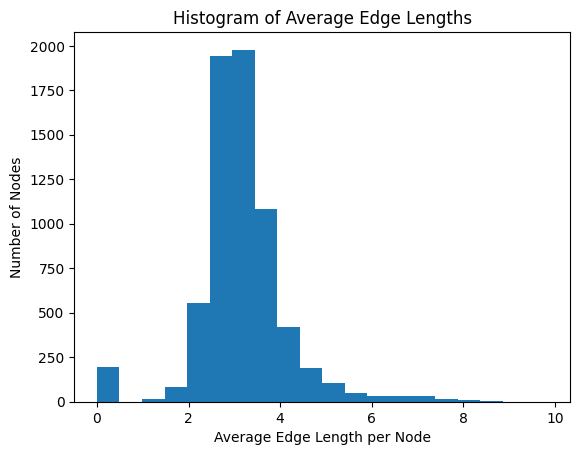

In [6]:
# prompt: Compute average edge length per node.
# Histogram that — you'll see dense vs sparse easily.

import matplotlib.pyplot as plt
import numpy as np
# Compute average edge length per node
avg_degree = g.degree()
print(f"Average degree: {np.mean(avg_degree)}")

# Calculate edge lengths (distances between nodes)
edge_lengths = []
for edge in g.es:
    source_node = edge.source
    target_node = edge.target
    distance = np.linalg.norm(unique_vectors[source_node] - unique_vectors[target_node])
    edge_lengths.append(distance)

# Compute average edge length per node
avg_edge_length_per_node = []
for node_index in range(g.vcount()):
  neighbor_indices = g.neighbors(node_index)
  edge_lengths_for_node = []
  for neighbor in neighbor_indices:
      # Find the edge connecting current node to its neighbor
      edge = g.get_eid(node_index, neighbor)
      edge_lengths_for_node.append(edge_lengths[edge])

  if edge_lengths_for_node:
    avg_edge_length_per_node.append(np.mean(edge_lengths_for_node))
  else:
    avg_edge_length_per_node.append(0)


# Plotting the histogram of average edge lengths
plt.hist(avg_edge_length_per_node, bins=20)  # Adjust bins as needed
plt.xlabel("Average Edge Length per Node")
plt.ylabel("Number of Nodes")
plt.title("Histogram of Average Edge Lengths")
plt.show()
